In [ ]:
# imports

In [108]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 14
MEDIUM = 16
LARGE = 20
THICK = 4
THIN = 3
ONE_TIMES_ONE = (9,8)
TWO_TIMES_ONE = (20,8)
TWO_TIMES_TWO = (20,15)
OPACITY = .25


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THICK)

plt.rc('font', size=MEDIUM, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [1]:
def rk4(f, yi, ti, h):
    k1 = h*f(ti, yi)
    k2 = h*f(ti+.5*h, yi+.5*k1)
    k3 = h*f(ti+.5*h, yi+.5*k2)
    k4 = h*f(ti+h, yi+k3)
    return yi + (k1 + 2*k2 + 2*k3 + k4)/6

In [35]:
class SIRS:
    def __init__(self, N, I0, fa, b, c):
        self.N = N
        self.S = N - I0
        self.I = I0
        self.R = 0
        self.fa = fa
        self.b = b
        self.c = c
        
    def S_dot(self, ti, Si):
        return self.c*self.R - self.fa(ti)*Si*self.I/self.N
    
    def I_dot(self, ti, Ii):
        return self.fa(ti)*self.S*Ii/self.N - self.b*Ii
    
    def R_dot(self, ti, Ri):
        return self.b*self.I - self.c*Ri

In [58]:
t.shape

(6,)

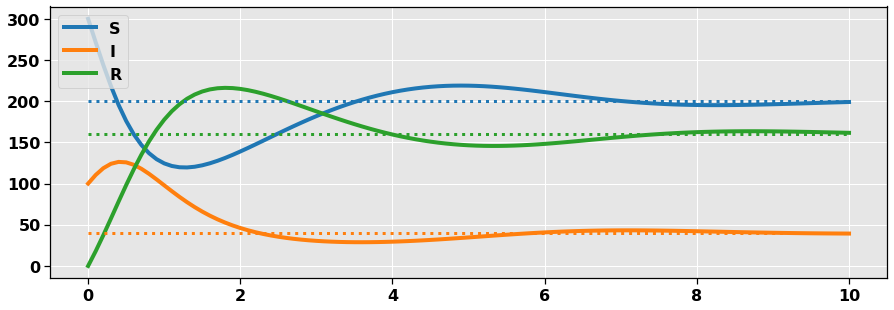

In [131]:
N = 400
I0 = 100
a = 4
b = 2
c = .5
sirs = SIRS(N, I0, (lambda t: a), b, c)

tn = 10
n = 100
S = np.ndarray(n+1)
I = np.ndarray(n+1)
R = np.ndarray(n+1)

S[0] = sirs.S
I[0] = sirs.I
R[0] = sirs.R

t = np.linspace(0, tn, n+1)
h = tn/n
for i in range(1,n+1):
    ti = t[i]
    S[i] = rk4(sirs.S_dot, sirs.S, ti, h)
    I[i] = rk4(sirs.I_dot, sirs.I, ti, h)
    R[i] = N - S[i] - I[i]

    sirs.S = S[i]
    sirs.I = I[i]
    sirs.R = R[i]

Seq = np.zeros(n+1) + b/a*N
Ieq = np.zeros(n+1) + (1-b/a)/(1+b/c)*N
Req = N - Seq - Ieq

fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(15,5))
ax = axes
ax.plot(t, S)
ax.plot(t, I)
ax.plot(t, R)

ax.plot(t, Seq, ':', color=COLORS[0], lw=3)
ax.plot(t, Ieq, ':', color=COLORS[1], lw=3)
ax.plot(t, Req, ':', color=COLORS[2], lw=3)
ax.legend(['S', 'I', 'R'], loc='upper left')

plt.show()

4